# YOLOv2 ONNX to ASTORE Example

In [1]:
import swat

### Connect to CAS

In [2]:
s = swat.CAS("<CAS-HOST>", <CAS-PORT>)

### Load ONNX model

ONNX model from https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/yolov2-coco 

In [3]:
# load onnx model
onnxfile = 'yolov2-coco-9.onnx'

# read onnx
s.loadactionset('aStore')
with open(onnxfile,'rb') as file:
    blob = file.read()

NOTE: Added action set 'aStore'.


### Check ONNX

In [4]:
# check onnx
blob_ = swat.blob(blob)
s.aStore.check(onnx=blob_)

NOTE: It is a valid ONNX model


+ Elapsed: 0.289s, user: 0.113s, sys: 0.105s, mem: 0.715mb

### Describe ONNX

In [5]:
# describe onnx
res = s.aStore.describe(onnx=blob_)
print(res)

[AStore.Tab.Description]

 Basic Information
 
               Attribute    Value
 0            IR Version        4
 1         Model Version        0
 2                Domain         
 3            Doc String         
 4         Producer Name  pytorch
 5      Producer Version      1.3
 6   Operator Set Domain         
 7  Operator Set Version        9

[AStore.Tab.InputValueInfo]

 Input Information
 
       Name     Length ValueType             Shape ElementType
 0  input.1  2076672.0    Tensor  (1, 3, 416, 416)       FLOAT

[AStore.Tab.OutputValueInfo]

 Output Information
 
   Name    Length ValueType             Shape ElementType
 0  218  287300.0    Tensor  (1, 425, 13, 13)       FLOAT

+ Elapsed: 0.51s, user: 0.17s, sys: 0.345s, mem: 1.88mb


### Load and process images

In [6]:
# Load images
s.loadactionset('image')

s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='data',
                  path='/path/to/data',
                  subdirectories=True)
s.image.loadimages(
    path='images',
    caslib='data',
    decode=True,
    addColumns=["CHANNELCOUNT", "CHANNELTYPE", "HEIGHT", "WIDTH"],
    casout=dict(name='imagesOrig', replication=0, replace=True),
)

# Resize images
encodedImage = True
inputColorOrder = 'RGB'

s.image.processimages(
    table='imagesOrig',
    steps=[
           {'step':{
               'stepType':'resize',
               'type':'LETTERBOX',
               'width': 416,
               'height': 416,
               'paddingmethod': 'CONSTANT',
               'b': 128,
               'g': 128,
               'r': 128
           }},
         {'options': {'functiontype': 'CONVERT_COLOR', 'type': 'BGR2RGB'}}
       ],
    decode=not encodedImage,
    copyvars=['_width_','_height_'],
    casout=dict(name='imagesResized',replace=True)
)


NOTE: Added action set 'image'.
NOTE: Cloud Analytic Services added the caslib 'data'.
NOTE: Loaded 10 images from /path/to/data/images into Cloud Analytic Services table imagesOrig.
NOTE: The table IMAGESORIG contains decoded images.
NOTE: 10 of 10 images were processed successfully and saved as encoded images to the Cloud Analytic Services table imagesResized.


,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(sasuser),imagesResized,10,7,"CASTable('imagesResized', caslib='CASUSERHDFS(..."


In [7]:
s.CASTable("imagesResized").head()

,_image_,_size_,_width_,_height_,_id_,_path_,_type_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,71068,993,925,1,/path/to/data/images/image7.jpg,jpg
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,55536,1216,1632,2,/path/to/data/images/image0.jpg,jpg
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,63556,1216,1632,3,/path/to/data/images/image10.jpg,jpg
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,85526,1632,1224,4,/path/to/data/images/image15.jpg,jpg
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,70883,960,1296,5,/path/to/data/images/image16.jpg,jpg


### Save to ASTORE

In [8]:
# Set labels
classList = [
"person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light",
"fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
"elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
"skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
"wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
"broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
"diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
"toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

YOLOv2 is a model that we specifically support. Because of this, the post-processing can all be completed using SAS.   
Description of some of the parameters:  
* `maxObjects`: the maximum number of objects to be detected in an image  
* `labels`: list of labels used in training the ONNX model  
* `modelType`: type of ONNX model, we currently only specifically support YOLOv2 and YOLOv3  
* `numAnchors`: number of anchor pairs (needed for YOLOv2)  
* `anchorBoxes`: specifies the anchor coordinate pairs  

In [9]:
s.aStore.saveas(
           table="imagesResized",
           rstore=dict(name="yolov2store", replace=True),
           onnx=blob_,
           inputs=[dict(vars=["_image_"],shape=[1,3,416,416],varbinaryType="UINT8", 
                        inputShapeOrder='NHWC', inputColorOrder='RGB',
                        modelShapeOrder='NCHW', modelColorOrder='RGB',
                        preprocess='NORMALIZE', normFactor=255,decoded=False)],
           modelType='YOLOV2',
           labels = classList,
           maxObjects=6,
           numAnchors=5,
           anchorBoxes=[1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071]
           )

NOTE: 203970894 bytes were written to the table "yolov2store" in the caslib "CASUSERHDFS(sasuser)".


+ Elapsed: 4.26s, user: 3.37s, sys: 2.57s, mem: 588mb

### Score

In [10]:
s.aStore.score(rstore="yolov2store", 
               table="imagesResized", 
               out=dict(name="imagesout",replace=True), 
               copyvars=("_path_","_id_","_width_","_height_")
              )

[OutputCasTables]

                 casLib       Name  Rows  Columns  \
 0  CASUSERHDFS(sasuser)  imagesout    10       41   
 
                                             casTable  
 0  CASTable('imagesout', caslib='CASUSERHDFS(mace...  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.171670  0.055264
 1  Creating the State  2.772434  0.892503
 2             Scoring  0.161148  0.051877
 3               Total  3.106359  1.000000

+ Elapsed: 3.19s, user: 13.7s, sys: 3.37s, mem: 340mb

In [11]:
# Create CASTable object from scored images table
tkimcore_results = s.CASTable("imagesout")

In [12]:
tkimcore_results.head()

,_P_Object0_,_Object0_x,_Object0_y,_Object0_width,_Object0_height,_P_Object1_,_Object1_x,_Object1_y,_Object1_width,_Object1_height,...,_Object1_,_Object2_,_Object3_,_Object4_,_Object5_,_nObjects_,_path_,_id_,_width_,_height_
0,0.494830,168.639359,59.040844,26.811722,57.833820,0.323233,213.742172,138.976639,45.186478,46.505859,...,car,car,car,car,car,6.0,/path/to/data/images/image7.jpg,1,993,925
1,0.370948,262.016968,114.698265,68.229309,53.354088,0.474974,300.483002,102.908989,70.559631,80.841209,...,chair,diningtable,chair,chair,cup,6.0,/path/to/data/images/image0.jpg,2,1216,1632
2,0.200708,135.340225,166.188873,137.345139,106.835693,0.865402,148.319962,76.291550,226.863297,317.706772,...,person,skateboard,,,,3.0,/path/to/data/images/image10.jpg,3,1216,1632
3,0.860465,128.791733,118.703911,204.040573,95.456902,NaN,NaN,NaN,NaN,NaN,...,,,,,,1.0,/path/to/data/images/image15.jpg,4,1632,1224
4,0.919839,40.752388,50.087151,247.253197,185.045433,NaN,NaN,NaN,NaN,NaN,...,,,,,,1.0,/path/to/data/images/image16.jpg,5,960,1296


### Extract bounding boxes
Use the SAS `fedsql` actionset to extract and scale bounding boxe dimensions

In [13]:
s.loadactionset('fedsql')

s.fedsql.execdirect(
    query="create table imagesDetected{options replace=true} as \
           select a._image_, a._dimension_, a._resolution_, a._imageformat_,\
                  a._size_, a._path_, a._type_, \
                  b._object0_x/416*a._width_ as _object0_x, \
                  b._object0_width/416*a._width_ as _object0_width, \
                  b._object0_y/416*a._height_ as _object0_y, \
                  b._object0_height/416*a._height_ as _object0_height, \
                  b._object1_x/416*a._width_ as _object1_x, \
                  b._object1_width/416*a._width_ as _object1_width, \
                  b._object1_y/416*a._height_ as _object1_y, \
                  b._object1_height/416*a._height_ as _object1_height, \
                  b._object2_x/416*a._width_ as _object2_x, \
                  b._object2_width/416*a._width_ as _object2_width, \
                  b._object2_y/416*a._height_ as _object2_y, \
                  b._object2_height/416*a._height_ as _object2_height, \
                  b._object3_x/416*a._width_ as _object3_x, \
                  b._object3_width/416*a._width_ as _object3_width, \
                  b._object3_y/416*a._height_ as _object3_y, \
                  b._object3_height/416*a._height_ as _object3_height, \
                  b._object4_x/416*a._width_ as _object4_x, \
                  b._object4_width/416*a._width_ as _object4_width, \
                  b._object4_y/416*a._height_ as _object4_y, \
                  b._object4_height/416*a._height_ as _object4_height, \
                  b._object5_x/416*a._width_ as _object5_x, \
                  b._object5_width/416*a._width_ as _object5_width, \
                  b._object5_y/416*a._height_ as _object5_y, \
                  b._object5_height/416*a._height_ as _object5_height, \
                  b._object0_ as _object0_, \
                  b._object1_ as _object1_, \
                  b._object2_ as _object2_, \
                  b._object3_ as _object3_, \
                  b._object4_ as _object4_, \
                  b._object5_ as _object5_, \
                  b._nobjects_ as _nobjects_ \
           from imagesOrig as a, imagesout as b \
           where a._id_ = b._id_"
)

NOTE: Added action set 'fedsql'.
NOTE: Table IMAGESDETECTED was created in caslib CASUSERHDFS(sasuser) with 10 rows returned.


+ Elapsed: 1.73s, user: 2.2s, sys: 3.1s, mem: 5.79e+03mb

The SAS `image` actionset includes an `extractDetectedObjects` action that will extract bounding boxes and their labels from a table

In [14]:
s.image.extractDetectedObjects(
    casOut={'name':'imagesBoxed', 'replace':True},
    table={'name':'imagesDetected'},
    maxObjects=6
)

NOTE: The table IMAGESDETECTED contains decoded images.
NOTE: 10 of 10 images were processed successfully and saved as encoded images to the Cloud Analytic Services table imagesBoxed.


,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(sasuser),imagesBoxed,10,4,"CASTable('imagesBoxed', caslib='CASUSERHDFS(ma..."


### Show images

NOTE: The table IMAGESBOXED contains encoded images.


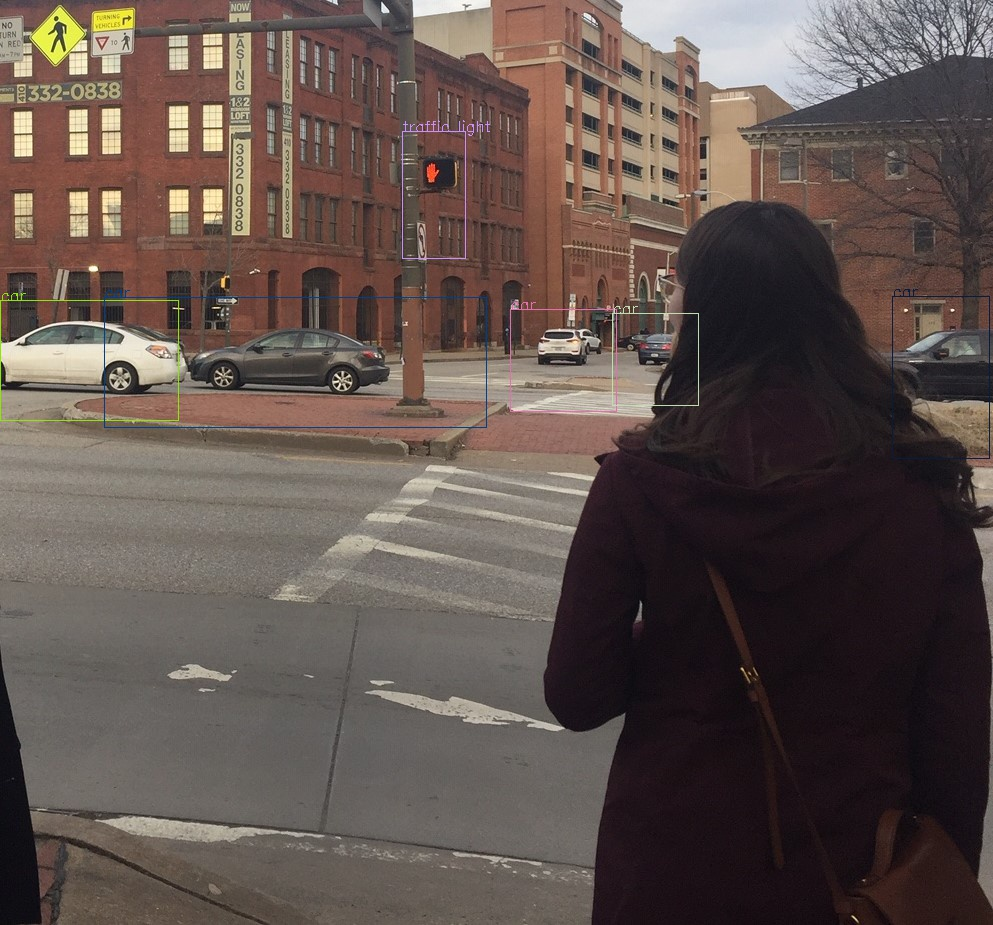

In [16]:
# Show images with bounding boxes plotted
for img in s.CASTable('imagesBoxed').fetchImages().Images['Image'][0:1]:
    display(img)